# PHYS381  Assignment \#3
## Due Wednesday Feb 8

Use scipy.integrate.romberg to evaluate the triple integral

  $$ \int_{x=0}^1 \int_{y=0}^\sqrt{1-x^2} \int_{z=0}^\sqrt{1-x^2-y^2} \frac{dz \, dy \, dx}{1 + x^2 + y^2 + z^2} $$
  
Try to obtain results for a range of precision eg. tol=1e-3, 1e-4, ...
See how small you can make the tolerance and still obtain a result in under a minute or so.
(It may be helpful to adjust divmax.)

Determine the number of calls $N$ to the integrand

  $$ \frac{1}{1 + x^2 + y^2 + z^2} $$
  
required for each value of tol.  Plot the graph of N versus tol and discuss the result.

<hr>

# Solutions

A triple integral is equivalent to three nested single integrals.  

In this case the $x$ integral
  $$ I =  \int_{x=0}^1  I_x(x) \, dx$$
has an x-integrand which is a $y$ integral
  $$ I_x(x) =  \int_{y=0}^\sqrt{1-x^2}  I_y(y,x) \, dy $$
and the y-integrand is a $z$ integral  
  $$ I_y(y,x) =  \int_{z=0}^\sqrt{1-x^2-y^2} I_z(z,y,x) \, dz$$
of the function 
  $$ I_z(z,y,x) =  \frac{1}{1 + x^2 + y^2 + z^2} $$
where the z-limits depend on $x$ and $y$, and the y-limits depend on $x$.



We are asked to use the "scipy.integrate.romberg" function to evaluate the triple integral.  From the documentation provided by "help(scipy.integrate.romberg)"

     Returns the integral of `function` (a function of one variable) over the interval (`a`, `b`).
 
we will have to make multiple nested calls to  "romberg".

In [4]:
import numpy as np
from scipy.integrate import romberg

In [5]:
# Call this version 1, with the expectation that we may
# need to add more features.
#
def integral_xyz_version1():
    return romberg( intv1_x, 0.0, 1.0 )

def intv1_x(x):
    lo, hi = 0.0, np.sqrt(1.0-x*x)
    return romberg( intv1_y, lo, hi, args=(x,) )

def intv1_y(y,x):
    lo, hi = 0.0, np.sqrt( 1.0-x*x-y*y  )
    return romberg( intv1_z, lo, hi, args=(y,x) )

def intv1_z(z,x,y):
    return 1.0 / (1.0 + x*x + y*y + z*z)

In [6]:
# print( integral_xyz_version1() )

Simply calling the integrating function

    integral_xyz_version1()

will generate many warning messages of the form

    C:\Users\bjackel\Miniconda3\envs\py34\lib\site-packages\scipy\integrate\quadrature.py:706: 
    AccuracyWarning: divmax (10) exceeded. Latest difference = 2.704740e-06  AccuracyWarning)
    
After a closer read of the documentation it looks like we should increase "divmax" to allow for additional sub-division steps.  For now we will also require a low "tol"erance level to speed up testing and development

In [13]:
tol = 1e-3    # use relaxed value for testing
divmax = 15   # increase default from 10

def integral_xyz_version2(show=False):
    return romberg( intv2_x, 0.0, 1.0, tol=tol, divmax=divmax, show=show )

def intv2_x(x):
    lo, hi = 0.0, np.sqrt( 1.0-x*x )
    return romberg( intv2_y, lo, hi, args=(x,), tol=tol, divmax=divmax )

def intv2_y(y,x):
    lo, hi = 0.0, np.sqrt( 1.0-x*x-y*y )
    return romberg( intv2_z, lo, hi, args=(y,x), tol=tol, divmax=divmax, vec_func=True )

def intv2_z(z,x,y):
    return 1.0 / (1.0 + x*x + y*y + z*z)
    
# print( integral_xyz_version2() )

Adjusting the integrator parameters as shown above in

    integral_xyz_version2()

will produce fewer error messages, but now they're complaining about the square-root

    C:\Users\bjackel\Miniconda3\envs\py34\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in sqrt
    C:\Users\bjackel\Miniconda3\envs\py34\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (15) exceeded. Latest difference = nan
  AccuracyWarning)
  
The np.sqrt function is only called in two places.  Adding some debugging print statements showed that the second call is the problem with an argument of the following form:

  $$1 - x^2 - y^2$$
  
Although this expression should in principle always be greater than or equal to zero, in practice numerical round-off errors could produce very small negative numbers. 

One way to deal with this is to test for negative numbers and replace them with zero.  Using "abs" also seems to work.

In [47]:
count_integrand = 0
tol = 1e-3
divmax = 10

def integral_xyz_version3(show=False):
    globals()['count_integrand'] = 0
    return romberg( intv3_x, 0.0, 1.0, tol=tol, divmax=divmax, show=show )

def intv3_x(x):
    lo, hi = 0.0, np.sqrt(1.0-x*x)
    return romberg( intv3_y, lo, hi, args=(x,), tol=tol, divmax=divmax )

def intv3_y(y,x):
    sqrt_arg = 1.0-x*x-y*y
    sqrt_arg = 0.0 if sqrt_arg<0 else sqrt_arg
    lo, hi = 0.0, np.sqrt( sqrt_arg )
    return romberg( intv3_z, lo, hi, args=(y,x), tol=tol, divmax=divmax, vec_func=True )

def intv3_z(z,x,y):
    globals()['count_integrand'] += 1
    return 1.0 / (1.0 + x*x + y*y + z*z)

In [48]:
tol = 1.0e-5
divmax = 10
print( integral_xyz_version3(show=True) )

Romberg integration of <function vectorize1.<locals>.vfunc at 0x000000000AC17F28> from [0.0, 1.0]

 Steps  StepSize   Results
     1  1.000000  0.272196 
     2  0.500000  0.320667  0.336823 
     4  0.250000  0.332997  0.337108  0.337127 
     8  0.125000  0.336070  0.337094  0.337093  0.337092 
    16  0.062500  0.336837  0.337092  0.337092  0.337092  0.337092 

The final result is 0.337092335091 after 17 function evaluations.
0.337092335091


We are now in a postion to do what the question asked for: calculate results and track integrand evaluations over a range of requested accuracies.

We found that "tol=1e-7" is noticably slower than 2e-7, so we stopped there.

In [56]:
result = []
divmax=15
for tol in [0.1, 1e-2, 1e-3, 2e-4, 1e-4, 2e-5, 1e-5, 5e-6, 2e-6, 1e-6, 5e-7, 2e-7]:
    result.append( (tol, integral_xyz_version3(), globals()['count_integrand'] ) )
    
result = np.array( result )
print( result )

[[  1.00000000e-01   3.25780726e-01   3.30000000e+01]
 [  1.00000000e-02   3.35071956e-01   1.27000000e+02]
 [  1.00000000e-03   3.36881778e-01   4.83000000e+02]
 [  2.00000000e-04   3.37026122e-01   2.07300000e+03]
 [  1.00000000e-04   3.37069531e-01   3.95100000e+03]
 [  2.00000000e-05   3.37089680e-01   2.60320000e+04]
 [  1.00000000e-05   3.37092335e-01   3.65310000e+04]
 [  5.00000000e-06   3.37094394e-01   6.94000000e+04]
 [  2.00000000e-06   3.37095213e-01   1.33930000e+05]
 [  1.00000000e-06   3.37095361e-01   1.62206000e+05]
 [  5.00000000e-07   3.37095627e-01   3.22365000e+05]
 [  2.00000000e-07   3.37095714e-01   1.23975600e+06]]


In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

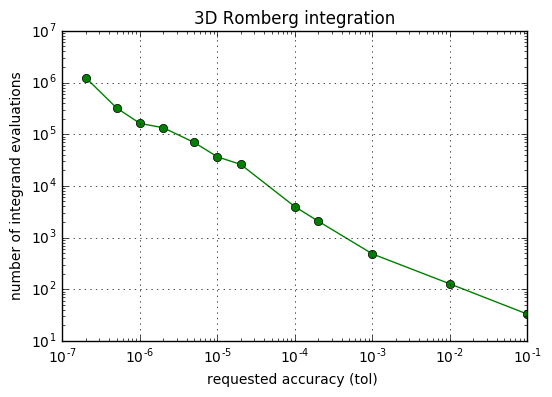

In [58]:
plt.plot( result[:,0], result[:,2], 'go-')
plt.xscale('log')
plt.yscale('log')
plt.grid('on')
plt.title('3D Romberg integration')
plt.xlabel('requested accuracy (tol) ')
plt.ylabel('number of integrand evaluations')

This plot shows an approximately linear relationship beween accuracy and number of function evaluations on a log-log scale.  In other words: if we want a factor of 10 better precision then it will require roughly 10x as many evaluations of the integrand.

# Optional material

Nothing below this point is required for this assignment.

## what about quad?

The scipy.integrate.quad function performs a 1D integral just like romberg.  Is it better?

As a quick test I replaced the "x" integral and found that roughly 5% more function evaluations were required. 

In [28]:
from scipy.integrate import quad
count_integrand = 0
tol = 1e-6
divmax = 15

def integral_xyz_version4():
    globals()['count_integrand'] = 0
    return quad( intv2_x, 0.0, 1.0, epsabs=tol )

def intv2_x(x):
    lo, hi = 0.0, np.sqrt(1.0-x*x)
    return romberg( intv2_y, lo, hi, args=(x,), tol=tol, divmax=divmax )

def intv2_y(y,x):
    lo, hi = 0.0, np.sqrt( np.abs( 1.0-x*x-y*y ) )
    return romberg( intv2_z, lo, hi, args=(y,x), tol=tol, divmax=divmax, vec_func=True )

def intv2_z(z,x,y):
    globals()['count_integrand'] += 1
    return 1.0 / (1.0 + x*x + y*y + z*z)

In [29]:
print( integral_xyz_version3(), count_integrand )
print( integral_xyz_version4(), count_integrand )

0.337095361376 162206
(0.33709538052728716, 1.8284618227058605e-08) 190016


In [35]:
count_integrand = 0
tol = 1e-6
divmax = 15

def integral_xyz_version5():
    globals()['count_integrand'] = 0
    return quad( intv5_x, 0.0, 1.0, epsabs=tol, limit=99 )

def intv5_x(x):
    lo, hi = 0.0, np.sqrt(1.0-x*x)
    return quad( intv2_y, lo, hi, args=(x,), epsabs=tol, limit=99 )

def intv2_y(y,x):
    lo, hi = 0.0, np.sqrt( np.abs( 1.0-x*x-y*y ) )
    return romberg( intv2_z, lo, hi, args=(y,x), tol=tol, divmax=divmax, vec_func=True )

def intv2_z(z,x,y):
    globals()['count_integrand'] += 1
    return 1.0 / (1.0 + x*x + y*y + z*z)

#print( integral_xyz_version3(), count_integrand )
#print( integral_xyz_version5(), count_integrand )

Trying to replace either of the "y" or "z" integrals resulted in a failure which in theory we could track down if it was important enough.

     C:\Users\bjackel\Miniconda3\envs\py34\lib\site-packages\scipy\integrate\quadrature.py in _difftrap(function, interval, numtraps)
     555         raise ValueError("numtraps must be > 0 in difftrap().")
     556     elif numtraps == 1:
     --> 557         return 0.5*(function(interval[0])+function(interval[1]))
     558     else:
     559         numtosum = numtraps/2

     TypeError: can't multiply sequence by non-int of type 'float'

## Change of variables

A transformation from Cartesian to spherical coordinates changes the integral into the following form

$$ \int_{\theta=0}^{\pi/2} \int_{\phi=0}^{\pi/2} \int_{\rho=0}^1 \frac{\rho^2 \sin\phi \, d\rho \, d\phi \, d\theta}{1 + \rho^2} $$

Straightforward numerical evaluation of this three-dimensional integral is roughly 100x faster than the original form (3ms versus 300ms).  This is an excellent illustration of how numerical computation can depend on how problems are expressed.

In [37]:
def integral_r_3d(show=False):
    return romberg( int3d_r, 0.0, 1.0, tol=tol, divmax=divmax, show=show )

def int3d_r(r):
    return romberg( int3d_phi, 0, np.pi/2.0, args=(r,), tol=tol, divmax=divmax )

def int3d_phi(phi, r):
    return romberg( int3d_theta, 0, np.pi/2.0, args=(phi, r), tol=tol, divmax=divmax, vec_func=True )

def int3d_theta(theta, phi, r):
    return np.sin(phi) * (1.0 - 1.0/(1+r*r))

tol = 1.0e-5
divmax = 15
print( integral_r_3d() )
%timeit integral_xyz_version2()
%timeit integral_r_3d()

0.337095774814
1 loop, best of 3: 338 ms per loop
100 loops, best of 3: 3.46 ms per loop


We further note that the transformation has resulted in three independent integrals

$$ \int_{\theta=0}^{\pi/2} \int_{\phi=0}^{\pi/2} \int_{\rho=0}^1 \sin\phi \left[ 1 - \frac{1}{1 + \rho^2} \right] d\rho \, d\phi \, d\theta $$

Evaluating them separately provides another factor of 30 improvement (0.15ms versus 3.5ms).

In [49]:
def integral_r_1d():
    Ir = romberg( int1d_r, 0.0, 1.0, tol=tol, divmax=divmax )
    Iphi = romberg( int1d_phi, 0.0, np.pi/2.0, tol=tol, divmax=divmax )
    Itheta = romberg( int1d_theta, 0.0, np.pi/2.0, tol=tol, divmax=divmax )
    return Ir * Iphi * Itheta
    
def int1d_r(r):
    return 1.0 - 1.0/( 1.0 + r*r )

def int1d_phi(phi):
    return np.sin(phi)

def int1d_theta(theta):
    return 1.0

tol = 1.0e-5
divmax = 15
print( integral_r_1d() )
%timeit integral_r_1d()
%timeit integral_r_3d()

0.337095774814
10000 loops, best of 3: 143 µs per loop
100 loops, best of 3: 3.49 ms per loop


Finally, it can be shown that each of the integrals has a closed form solution

  $$ \left( 1 - \frac{\pi}{4} \right) \left( \cos\phi \right|_0^{\pi/2} \int_{\theta=0}^{\pi/2} d\theta $$

so that we can get an "exact" solution very quickly

  $$ \left( 1 - \frac{\pi}{4} \right) \frac{\pi}{2} = \frac{\pi}{2} - \frac{\pi^2}{8} $$

In [11]:
exact =  np.pi/2.0 - np.pi**2 / 8.0
print( exact ) 

0.3370957766587268


In [39]:
tol = 1.0e-6
divmax = 20
print( exact - integral_xyz_version3() )
print( exact - integral_r_3d() )

4.15283060773e-07
-9.42791400504e-11


## Error: actual vs. predicted

It appears that the actual error for this case is consistently lower than the estimated error.  It is usually a good thing to be conservative with error estimates.

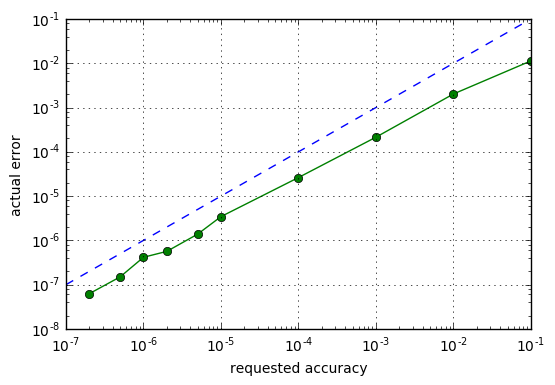

In [41]:
plt.plot( result[:,0], np.abs( exact - result[:,1] ), 'go-')
plt.xscale('log')
plt.yscale('log')
plt.grid('on')
plt.xlabel('requested accuracy')
plt.ylabel('actual error')
plt.plot( [1e-7, 1e-1], [1e-7,1e-1], 'b--')

## Nested functions

Python allows us to define functions inside other functions.  This provides another way to share variables between the inner and outer integrals.  It also "hides" the inner functions to avoid naming conflicts.

In [51]:
def integral_nested(show=False):
    
    global count_integrand 
    count_integrand = 0 
    
    def integrand_x(x):
        
        def integrand_y(y):

            def integrand_z(z):
                global count_integrand 
                count_integrand += 1
                return 1.0 / (1.0 + x*x + y*y + z*z)            
            
            lo, hi = 0.0, np.sqrt( np.abs( 1.0-x*x-y*y ) )
            return romberg( integrand_z, lo, hi, tol=tol, divmax=divmax, vec_func=True )

        lo, hi = 0.0, np.sqrt(1.0-x*x)
        return romberg( integrand_y, lo, hi, tol=tol, divmax=divmax )

    return romberg( integrand_x, 0.0, 1.0, tol=tol, divmax=divmax, show=show )
    
    
tol = 1.0e-6
divmax = 20
assert( np.abs( exact - integral_nested() ) <= 1e-6 )

## Ineffective optimization

The integrand is being called thousands of times, so we might expect that it would be worth trying to make it less computationally expensive.  However, applying all the standard tricks to remove redundant calculations only gives us a 10% improvement.

In [52]:
def integral_nested_faster(show=False):
    
    def integrand_x(x):
        
        def integrand_y(y):            
            
            def integrand_z(z):
                return 1.0 / (one_plus_x2_y2 + z*z)
            
            y2 = y*y
            lo, hi = 0.0, np.sqrt( np.abs( 1.0-x2-y2 ) )
            one_plus_x2_y2 = 1.0 + x2 + y2
            return romberg( integrand_z, lo, hi, tol=tol, divmax=divmax, vec_func=True )        
        
        x2 = x*x
        lo, hi = 0.0, np.sqrt(1.0-x2)
        return romberg( integrand_y, lo, hi, tol=tol, divmax=divmax )

    return romberg( integrand_x, 0.0, 1.0, tol=tol, divmax=divmax, show=show )

tol = 1.0e-6
divmax = 20
assert( np.abs( exact - integral_nested_faster() ) <= 1e-6 )

In [45]:
tol = 1.0e-5
divmax = 15
%timeit integral_nested()
%timeit integral_nested_faster()

1 loop, best of 3: 340 ms per loop
1 loop, best of 3: 317 ms per loop


### profiling

We can use the %prun magic command to run the profiler.  This will collect information about how much time is spent in each function.  It turns out that "integrand_z" is only the third most expensive element.  Even if we could reduce the integrand time by 50%, we would only decrease the overall run time by about 15%.

One alternative would be to go and read the soruce code for "quadrature.py" and see if we can somehow speed things up.

Another would be to somehow simplify the integral eg. variable transformation.

Or we could simply stop worrying, if this integral is a small part of a larger program with more expensive hot-spots.

In [46]:
%prun integral_nested()

<pre>
    374434 function calls (337555 primitive calls) in 0.400 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   7077/1    0.090    0.000    0.400    0.400 quadrature.py:593(romberg)
  29634/5    0.070    0.000    0.400    0.080 quadrature.py:541(_difftrap)
    36531    0.069    0.000    0.069    0.000 <ipython-input-43-29930bc8af6c>:10(integrand_z)
    22557    0.036    0.000    0.036    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    49211    0.029    0.000    0.029    0.000 quadrature.py:567(_romberg_diff)
    22557    0.027    0.000    0.073    0.000 fromnumeric.py:1743(sum)
     7059    0.021    0.000    0.391    0.000 <ipython-input-43-29930bc8af6c>:8(integrand_y)
    22557    0.020    0.000    0.020    0.000 {built-in method arange}
    36531    0.011    0.000    0.079    0.000 quadrature.py:111(vfunc)
    49211    0.006    0.000    0.006    0.000 {method 'append' of 'list' objects}
    180/6    0.006    0.000    0.400    0.067 quadrature.py:114(vfunc)
    22737    0.006    0.000    0.006    0.000 {built-in method isinstance}
    22557    0.005    0.000    0.041    0.000 _methods.py:31(_sum)
    38037    0.003    0.000    0.003    0.000 {built-in method abs}
     7077    0.002    0.000    0.002    0.000 quadrature.py:85(vectorize1)
      144    0.000    0.000    0.000    0.000 {built-in method empty}
      180    0.000    0.000    0.000    0.000 numeric.py:2064(isscalar)
      144    0.000    0.000    0.000    0.000 numeric.py:414(asarray)
       17    0.000    0.000    0.400    0.024 <ipython-input-43-29930bc8af6c>:6(integrand_x)
      144    0.000    0.000    0.000    0.000 {built-in method getattr}
      144    0.000    0.000    0.000    0.000 {built-in method array}
      144    0.000    0.000    0.000    0.000 {built-in method len}
        1    0.000    0.000    0.400    0.400 {built-in method exec}
        1    0.000    0.000    0.400    0.400 <ipython-input-43-29930bc8af6c>:1(integral_nested)
        1    0.000    0.000    0.400    0.400 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
</pre>